### 1- Packages

The h5py package is a Pythonic interface to the HDF5 binary data format. It lets you store huge amounts of numerical data, and easily manipulate that data from NumPy. For example, you can slice into multi-terabyte datasets stored on disk, as if they were real NumPy arrays.

In [1]:
pip install h5py

You should consider upgrading via the '/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2 #Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
np.random.seed(1)

/opt/homebrew/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
# GRADED FUNCTION: zero_pad
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=(0, 0))
    
    return X_pad

In [4]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
# x
print ("x.shape =\n", x.shape)
x_pad = zero_pad(x, 2)
print ("x_pad.shape =\n", x_pad.shape)


x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)


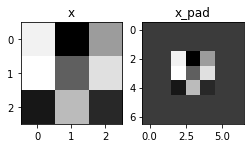

In [5]:

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
   

In [6]:
def conv_single_step(a_slice_prev, W, b):
    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    Z = Z + float(b)
    return Z

In [7]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)
Z = conv_single_step(a_slice_prev, W, b)
print(Z)

-6.999089450680221


Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function

In [8]:
# conv_forward
def conv_forward(A_prev, W, b, hparameters):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
    (f, f, n_C_prev, n_C) = W.shape[0], W.shape[1], W.shape[2], W.shape[3]
    
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume
    n_H = int(int(n_H_prev - f + 2*pad)/stride +1)
    n_W = int(int(n_W_prev - f + 2*pad)/stride +1)
    
    Z = np.zeros([m, n_H, n_W, n_C])
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m): # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]
        
        for h in range(n_H):
            vert_start = stride * h
            vert_end = vert_start + f
            
            for w in range(n_W):
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range(n_C):
                    
                    a_slice_prev = A_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :]
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
                    
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache
    

In [9]:
np.random.seed(1)
A_prev = np.random.randn(10, 5, 7, 4)
W = np.random.randn(3, 3, 4 , 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad": 1,
              "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


In [10]:
def pool_forward(A_prev, hparameters, mode="max"):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int((n_H_prev - f) / stride + 1)
    n_W = int((n_W_prev - f) / stride + 1)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            vert_start = h * stride
            vert_end = vert_start + f
            
            for w in range(n_W):
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                for c in range(n_C):
                    a_prev_slice = A_prev[i]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])
    cache = (A_prev, hparameters)
    assert(A.shape == (m, n_H, n_W, n_C))
    return A, cache
                    

In [11]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [

In [12]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    ### START CODE HERE ### (≈1 line)
    mask = None
    ### END CODE HERE ###
    (k, l) = x.shape
    
    return mask

In [13]:
np.random.seed(1)
x = np.random.randn(3,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069   0.3190391 ]]
mask =  None


In [14]:
np.argmax(x)
# x.shape

6

In [15]:
def conv_backward(dZ, cache):
    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros(A_prev.shape)
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = stride * h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start +f
                    
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    return dA_prev, dW, db
       
                    

In [16]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

assert type(dA) == np.ndarray, "Output must be a np.ndarray"
assert type(dW) == np.ndarray, "Output must be a np.ndarray"
assert type(db) == np.ndarray, "Output must be a np.ndarray"
assert dA.shape == (10, 4, 4, 3), f"Wrong shape for dA  {dA.shape} != (10, 4, 4, 3)"
assert dW.shape == (2, 2, 3, 8), f"Wrong shape for dW {dW.shape} != (2, 2, 3, 8)"
assert db.shape == (1, 1, 1, 8), f"Wrong shape for db {db.shape} != (1, 1, 1, 8)"
assert np.isclose(np.mean(dA), 1.4524377), "Wrong values for dA"
assert np.isclose(np.mean(dW), 1.7269914), "Wrong values for dW"
assert np.isclose(np.mean(db), 7.8392325), "Wrong values for db"

print("\033[92m All tests passed.")

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838
 All tests passed.


In [17]:
def create_mask_from_window(x):
    
    mask =(x==np.max(x))
    
    return mask

In [18]:
np.random.seed(1)
x = np.random.randn(2, 3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x = np.array([[-1, 2, 3],
              [2, -3, 2],
              [1, 5, -2]])

mask = create_mask_from_window(x)



print("\033[92m All tests passed.")

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]
 All tests passed.


In [19]:
def distribute_value(dz, shape):
    (n_H, n_W) = shape
    average = np.prod(shape)
    a = (dz/average)*np.ones(shape)
    
    return a

In [20]:
a = distribute_value(2, (2, 2))
print('distributed value =', a)


distributed value = [[0.5 0.5]
 [0.5 0.5]]


In [21]:
np.prod([[1.,2.],[3.,4.]], axis=0)

array([3., 8.])

In [22]:
np.prod((2,2))

4

In [23]:
def pool_backward(dA, cache, mode="max"):
    
    (A_prev, hparameters) = cache
    stride = hparameters["stride"]
    f = hparameters["f"]
    m, n_H_prev, n_W_prev, n_C_prev = dA.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):
        a_prev = A_prev[i, :, :, :]
        
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = stride * h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f
                    
                    if mode == "max":
                        
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                        
                        
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev
    

In [24]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
print(A.shape)
print(cache[0].shape)
dA = np.random.randn(5, 4, 2, 2)

dA_prev1 = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev1[1,1] = ', dA_prev1[1, 1])  
print()
dA_prev2 = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev2[1,1] = ', dA_prev2[1, 1]) 

assert type(dA_prev1) == np.ndarray, "Wrong type"
assert dA_prev1.shape == (5, 5, 3, 2), f"Wrong shape {dA_prev1.shape} != (5, 5, 3, 2)"
assert np.allclose(dA_prev1[1, 1], [[0, 0], 
                                    [ 5.05844394, -1.68282702],
                                    [ 0, 0]]), "Wrong values for mode max"
assert np.allclose(dA_prev2[1, 1], [[0.08485462,  0.2787552], 
                                    [1.26461098, -0.25749373], 
                                    [1.17975636, -0.53624893]]), "Wrong values for mode average"
print("\033[92m All tests passed.")

(5, 4, 2, 2)
(5, 5, 3, 2)
mode = max
mean of dA =  0.14571390272918056
dA_prev1[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev2[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
 All tests passed.
